In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import monotonically_increasing_id,col
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark import SparkConf, SparkContext

In [2]:
spark = pyspark.sql.SparkSession.builder.appName('test').getOrCreate()
conf = SparkConf().setMaster("yarn-client")

In [3]:
movie_rating = spark.read.format('csv').options(header='true', inferSchema='true').load('Movie Rating with null.csv')
movie_rating = movie_rating.withColumnRenamed("Toy Story 3 (2010)","Toy_Story").withColumnRenamed("Inception (2010)","Inception").withColumnRenamed("Skyfall (2012)","Skyfall").withColumnRenamed("Her (2013)","Her").withColumnRenamed("Parasite (2019)","Parasite").withColumnRenamed("A Star Is Born (2018)","A_Star_Is_Born").withColumnRenamed("Marriage Story (2019)","Marriage_Story").withColumnRenamed("Gone Girl (2014)","Gone_Girl").withColumnRenamed("The Nice Guys (2016)","The_Nice_Guys").withColumnRenamed("Avengers: End Game (2019)","Avengers_End_Game").withColumnRenamed("Train to Busan (2016)","Train_to_Busan")
movie_rating.show(10)

+--------+---------+---------+-------+----+--------+--------------+--------------+---------+-------------+-----------------+--------------+
|USERNAME|Toy_Story|Inception|Skyfall| Her|Parasite|A_Star_Is_Born|Marriage_Story|Gone_Girl|The_Nice_Guys|Avengers_End_Game|Train_to_Busan|
+--------+---------+---------+-------+----+--------+--------------+--------------+---------+-------------+-----------------+--------------+
|   adind|     null|        5|      4|null|    null|             4|          null|        5|            4|                5|          null|
|    adji|        4|        5|      4|   3|       5|             4|          null|     null|         null|                5|          null|
|   agrah|        3|     null|   null|null|       5|          null|          null|        5|            2|                5|             5|
|   ajeng|        4|     null|   null|null|    null|             5|          null|        5|         null|                4|             5|
|   alfin|     null|

In [4]:
movie_rating_long_data = movie_rating.selectExpr("USERNAME", "stack(11, 'Toy_Story',Toy_Story,'Inception',Inception, 'Skyfall',Skyfall,'Her', Her, 'Parasite',Parasite,'A_Star_Is_Born',A_Star_Is_Born,'Marriage_Story',Marriage_Story,'Gone_Girl',Gone_Girl,'The_Nice_Guys',The_Nice_Guys,'Avengers_End_Game',Avengers_End_Game,'Train_to_Busan',Train_to_Busan) as (Movie,Rating)").where("Rating is not null")
movie_rating_long_data.show(10)

+--------+-----------------+------+
|USERNAME|            Movie|Rating|
+--------+-----------------+------+
|   adind|        Inception|     5|
|   adind|          Skyfall|     4|
|   adind|   A_Star_Is_Born|     4|
|   adind|        Gone_Girl|     5|
|   adind|    The_Nice_Guys|     4|
|   adind|Avengers_End_Game|     5|
|    adji|        Toy_Story|     4|
|    adji|        Inception|     5|
|    adji|          Skyfall|     4|
|    adji|              Her|     3|
+--------+-----------------+------+
only showing top 10 rows



In [5]:
users = movie_rating_long_data.select('USERNAME').distinct()
users = users.coalesce(1)
users = users.withColumn('userIntId',monotonically_increasing_id()).persist()
users.show(10)

+--------+---------+
|USERNAME|userIntId|
+--------+---------+
|  muham3|        0|
|   khair|        1|
|    rian|        2|
|   finaa|        3|
|   meirl|        4|
|   khani|        5|
|   natha|        6|
|   agrah|        7|
|   danar|        8|
|   rizas|        9|
+--------+---------+
only showing top 10 rows



In [6]:
movies = movie_rating_long_data.select('Movie').distinct()
movies = movies.coalesce(1)
movies = movies.withColumn('movieID',monotonically_increasing_id()).persist()
movies.show(10)

+-----------------+-------+
|            Movie|movieID|
+-----------------+-------+
|   Marriage_Story|      0|
|        Toy_Story|      1|
|   A_Star_Is_Born|      2|
|   Train_to_Busan|      3|
|              Her|      4|
|        Gone_Girl|      5|
|    The_Nice_Guys|      6|
|          Skyfall|      7|
|Avengers_End_Game|      8|
|         Parasite|      9|
+-----------------+-------+
only showing top 10 rows



In [7]:
ratings_w_int_ids = movie_rating_long_data.join(users,'USERNAME','left').join(movies,'Movie','left')
ratings_w_int_ids.show(10)

+-----------------+--------+------+---------+-------+
|            Movie|USERNAME|Rating|userIntId|movieID|
+-----------------+--------+------+---------+-------+
|        Inception|   adind|     5|       54|     10|
|          Skyfall|   adind|     4|       54|      7|
|   A_Star_Is_Born|   adind|     4|       54|      2|
|        Gone_Girl|   adind|     5|       54|      5|
|    The_Nice_Guys|   adind|     4|       54|      6|
|Avengers_End_Game|   adind|     5|       54|      8|
|        Toy_Story|    adji|     4|       47|      1|
|        Inception|    adji|     5|       47|     10|
|          Skyfall|    adji|     4|       47|      7|
|              Her|    adji|     3|       47|      4|
+-----------------+--------+------+---------+-------+
only showing top 10 rows



In [8]:
ratings_data = ratings_w_int_ids.select(col('userIntId').alias('userId'),col('movieID').alias('movieId'),col('Rating').alias('rating'))
ratings_data.show(10)

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|    54|     10|     5|
|    54|      7|     4|
|    54|      2|     4|
|    54|      5|     5|
|    54|      6|     4|
|    54|      8|     5|
|    47|      1|     4|
|    47|     10|     5|
|    47|      7|     4|
|    47|      4|     3|
+------+-------+------+
only showing top 10 rows



In [9]:
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

In [10]:
(training_data, test_data) = ratings_data.randomSplit([0.8, 0.2],seed=47)

In [11]:
als=ALS(rank=2,maxIter=15,implicitPrefs=False,regParam=0.2,userCol="userId",itemCol="movieId"
        ,ratingCol="rating",coldStartStrategy="drop",nonnegative=True)
model = als.fit(training_data)
test_predictions = model.transform(test_data)
RMSE = evaluator.evaluate(test_predictions)
print(RMSE)

0.6876394305301073


In [12]:
recs=model.recommendForAllUsers(11).toPandas()
nrecs=recs.recommendations.apply(pd.Series) \
            .merge(recs, right_index = True, left_index = True) \
            .drop(["recommendations"], axis = 1) \
            .melt(id_vars = ['userId'], value_name = "recommendation") \
            .drop("variable", axis = 1) \
            .dropna() 

In [13]:
nrecs=nrecs.sort_values('userId')
nrecs=pd.concat([nrecs['recommendation'].apply(pd.Series), nrecs['userId']], axis = 1)
nrecs.columns = ['Movie_index', 'Rating', 'UserID_index']

In [14]:
nrecs.head()

,Movie_index,Rating,UserID_index
421,2.0,3.667572,0
580,4.0,3.075671,0
368,1.0,3.792466,0
315,7.0,3.812140,0
103,8.0,4.340511,0


In [15]:
users_pandas = users.toPandas()
users_pandas.head()

,USERNAME,userIntId
0,muham3,0
1,khair,1
2,rian,2
3,finaa,3
4,meirl,4


In [16]:
movies_pandas = movies.toPandas()
movies_pandas.head()

,Movie,movieID
0,Marriage_Story,0
1,Toy_Story,1
2,A_Star_Is_Born,2
3,Train_to_Busan,3
4,Her,4


In [17]:
movie_rating_pandas = movie_rating.toPandas().fillna(0).set_index('USERNAME')
movie_rating_pandas = movie_rating_pandas.stack().to_frame().reset_index().rename(columns={'level_1':'Movie_Title', 0:'Rating'})
movie_rating_pandas.head()

,USERNAME,Movie_Title,Rating
0,adind,Toy_Story,0.0
1,adind,Inception,5.0
2,adind,Skyfall,4.0
3,adind,Her,0.0
4,adind,Parasite,0.0


In [18]:
recommendation_output = nrecs.merge(users_pandas,how='left',left_on='UserID_index',right_on='userIntId')
recommendation_output = recommendation_output.merge(movies_pandas,how='left',left_on='Movie_index',right_on='movieID')
recommendation_output = recommendation_output[['USERNAME','Movie','Rating']].sort_values(by=['USERNAME','Rating'],ascending=[True,False]).reset_index(drop=True)
recommendation_output = recommendation_output.merge(movie_rating_pandas,left_on = ['USERNAME','Movie'],right_on=['USERNAME','Movie_Title'],how='left')
recommendation_output = recommendation_output.loc[recommendation_output['Rating_y'] == 0]
recommendation_output = recommendation_output[['USERNAME','Movie','Rating_x']].rename(columns={'Rating_x':'Rating_Prediction'})
recommendation_output['Rating_Prediction'] = recommendation_output['Rating_Prediction'].round(2)
#recommendation_output.to_csv('recommendation_output.csv')
recommendation_output.head()

,USERNAME,Movie,Rating_Prediction
0,adind,Parasite,4.92
2,adind,Train_to_Busan,4.76
6,adind,Toy_Story,4.26
8,adind,Marriage_Story,4.06
10,adind,Her,3.46


In [19]:
movie_rating_pandas = movie_rating.toPandas()
movie_rating_pandas = movie_rating_pandas.set_index('USERNAME')
movie_rating_pandas.head()

,Toy_Story,Inception,Skyfall,Her,Parasite,A_Star_Is_Born,Marriage_Story,Gone_Girl,The_Nice_Guys,Avengers_End_Game,Train_to_Busan
USERNAME,,,,,,,,,,,
adind,NaN,5.0,4.0,NaN,NaN,4.0,NaN,5.0,4.0,5.0,NaN
adji,4.0,5.0,4.0,3.0,5.0,4.0,NaN,NaN,NaN,5.0,NaN
agrah,3.0,NaN,NaN,NaN,5.0,NaN,NaN,5.0,2.0,5.0,5.0
ajeng,4.0,NaN,NaN,NaN,NaN,5.0,NaN,5.0,NaN,4.0,5.0
alfin,NaN,NaN,5.0,NaN,4.0,4.0,NaN,NaN,NaN,5.0,NaN


In [20]:
movie_rating_pandas2 = movie_rating_pandas.stack().to_frame().reset_index().rename(columns={'level_1':'Movie_Title', 0:'Rating'})
movie_rating_pandas2.head(10)

,USERNAME,Movie_Title,Rating
0,adind,Inception,5.0
1,adind,Skyfall,4.0
2,adind,A_Star_Is_Born,4.0
3,adind,Gone_Girl,5.0
4,adind,The_Nice_Guys,4.0
5,adind,Avengers_End_Game,5.0
6,adji,Toy_Story,4.0
7,adji,Inception,5.0
8,adji,Skyfall,4.0
9,adji,Her,3.0


In [21]:
movie_rating_pandas3 = movie_rating_pandas2.append(recommendation_output.rename(columns={'Movie':'Movie_Title','Rating_Prediction':'Rating'}))
movie_rating_pandas3.head()

,USERNAME,Movie_Title,Rating
0,adind,Inception,5.0
1,adind,Skyfall,4.0
2,adind,A_Star_Is_Born,4.0
3,adind,Gone_Girl,5.0
4,adind,The_Nice_Guys,4.0


In [22]:
movie_rating_pivot = movie_rating_pandas3.pivot(index='USERNAME',columns='Movie_Title',values='Rating')
movie_rating_pivot['Group 1'] = movie_rating_pivot.loc[:,['Toy_Story','Her', 'A_Star_Is_Born','Marriage_Story','The_Nice_Guys']].mean(axis=1)
movie_rating_pivot['Group 2'] = movie_rating_pivot.loc[:,['Inception','Skyfall', 'Parasite','Avengers_End_Game','Train_to_Busan','Gone_Girl']].mean(axis=1)
movie_rating_pivot = movie_rating_pivot.drop(index=['jeann','nurw','hayya','grita','rian','ashle'])
movie_rating_pivot.head()

Movie_Title,A_Star_Is_Born,Avengers_End_Game,Gone_Girl,Her,Inception,Marriage_Story,Parasite,Skyfall,The_Nice_Guys,Toy_Story,Train_to_Busan,Group 1,Group 2
USERNAME,,,,,,,,,,,,,
adind,4.0,5.0,5.00,3.46,5.00,4.06,4.92,4.00,4.00,4.26,4.76,3.956,4.780000
adji,4.0,5.0,4.35,3.00,5.00,3.81,5.00,4.00,3.44,4.00,4.46,3.650,4.635000
agrah,3.7,5.0,5.00,3.10,4.16,3.65,5.00,3.84,2.00,3.00,5.00,3.090,4.666667
ajeng,5.0,4.0,5.00,3.34,4.47,3.93,4.76,4.14,3.54,4.00,5.00,3.962,4.561667
alfin,4.0,5.0,4.13,3.08,4.13,3.63,4.00,5.00,3.26,3.80,4.24,3.554,4.416667


In [23]:
from sklearn.preprocessing import StandardScaler
titles = ['Toy_Story','Her', 'A_Star_Is_Born','Marriage_Story','The_Nice_Guys','Inception','Skyfall', 'Parasite','Avengers_End_Game','Train_to_Busan','Gone_Girl']
x = movie_rating_pivot.loc[:, titles].values
x = StandardScaler().fit_transform(x)

In [24]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2'])
principalDf.head()

,PC1,PC2
0,-2.313144,-0.286019
1,-0.821883,-0.329308
2,0.877392,-0.403431
3,-1.819397,1.161862
4,-0.095901,-0.984052


In [25]:
movie_rating_pivot['PC1'] = principalDf['PC1'].tolist()
movie_rating_pivot['PC2'] = principalDf['PC2'].tolist()
movie_rating_pivot.head()

Movie_Title,A_Star_Is_Born,Avengers_End_Game,Gone_Girl,Her,Inception,Marriage_Story,Parasite,Skyfall,The_Nice_Guys,Toy_Story,Train_to_Busan,Group 1,Group 2,PC1,PC2
USERNAME,,,,,,,,,,,,,,,
adind,4.0,5.0,5.00,3.46,5.00,4.06,4.92,4.00,4.00,4.26,4.76,3.956,4.780000,-2.313144,-0.286019
adji,4.0,5.0,4.35,3.00,5.00,3.81,5.00,4.00,3.44,4.00,4.46,3.650,4.635000,-0.821883,-0.329308
agrah,3.7,5.0,5.00,3.10,4.16,3.65,5.00,3.84,2.00,3.00,5.00,3.090,4.666667,0.877392,-0.403431
ajeng,5.0,4.0,5.00,3.34,4.47,3.93,4.76,4.14,3.54,4.00,5.00,3.962,4.561667,-1.819397,1.161862
alfin,4.0,5.0,4.13,3.08,4.13,3.63,4.00,5.00,3.26,3.80,4.24,3.554,4.416667,-0.095901,-0.984052


In [26]:
len(movie_rating_pivot)

50

In [27]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [28]:
X = movie_rating_pivot[['PC1','PC2']]

In [29]:
cluster_range = range(2,15)
cluster_sscore = []

for num_clusters in cluster_range:
    model = KMeans(num_clusters)
    model.fit(X)
    predicted_label = model.predict(X)
    cluster_sscore.append(silhouette_score(X,predicted_label))

In [30]:
data_cluster = pd.DataFrame(list(zip(cluster_range, cluster_sscore)), columns =['Number Cluster', 'Silhouette Score']).sort_values('Silhouette Score',ascending=False).reset_index(drop=True)
data_cluster.head()

,Number Cluster,Silhouette Score
0,3,0.488804
1,2,0.476261
2,4,0.417176
3,10,0.397234
4,9,0.395863


In [31]:
model = KMeans(n_clusters=3)
model.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [32]:
predicted_label = model.predict(X)
predicted_label

array([0, 0, 2, 0, 2, 0, 0, 2, 0, 1, 2, 0, 1, 0, 2, 2, 2, 2, 0, 0, 2, 0,
       1, 2, 0, 0, 1, 0, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 2, 0, 2,
       0, 0, 0, 2, 0, 2])

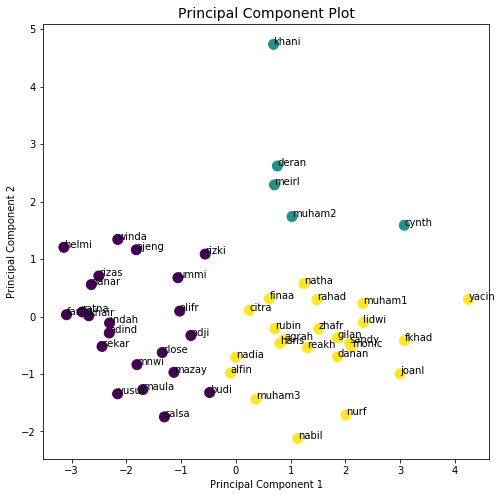

In [38]:
fig, ax = plt.subplots(figsize=(8,8))
plt.scatter(movie_rating_pivot['PC1'], movie_rating_pivot['PC2'], c=predicted_label, s=100)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Principal Component Plot',fontsize=14)

for i, txt in enumerate(movie_rating_pivot.index):
    ax.annotate(txt, (movie_rating_pivot['PC1'][i], movie_rating_pivot['PC2'][i]))
    
plt.savefig('Principal Component Plot.png')    
plt.show()

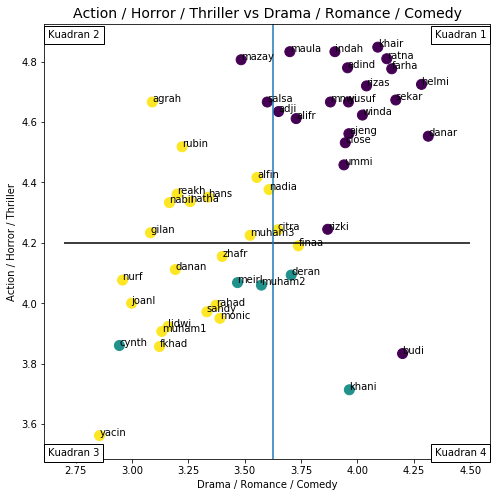

In [39]:
fig, ax = plt.subplots(figsize=(8,8))
plt.scatter(movie_rating_pivot['Group 1'], movie_rating_pivot['Group 2'], c=predicted_label, s=100)

plt.xlabel('Drama / Romance / Comedy')
plt.ylabel('Action / Horror / Thriller')
plt.title('Action / Horror / Thriller vs Drama / Romance / Comedy',fontsize=14)

for i, txt in enumerate(movie_rating_pivot.index):
    ax.annotate(txt, (movie_rating_pivot['Group 1'][i], movie_rating_pivot['Group 2'][i]))

plt.axvline(x=3.625)
plt.hlines(y=4.2,xmin=2.7,xmax=4.5)
plt.text(4.3425,4.88,"Kuadran 1",bbox=dict(facecolor='white'))
plt.text(2.6275,4.88,"Kuadran 2",bbox=dict(facecolor='white'))
plt.text(2.6275,3.49425,"Kuadran 3",bbox=dict(facecolor='white'))
plt.text(4.3425,3.49425,"Kuadran 4",bbox=dict(facecolor='white'))

plt.savefig('Movie Market Segmentation.png')
plt.show()

In [40]:
movie_rating_pivot['Label'] = predicted_label
movie_rating_pivot.head()

Movie_Title,A_Star_Is_Born,Avengers_End_Game,Gone_Girl,Her,Inception,Marriage_Story,Parasite,Skyfall,The_Nice_Guys,Toy_Story,Train_to_Busan,Group 1,Group 2,PC1,PC2,Label
USERNAME,,,,,,,,,,,,,,,,
adind,4.0,5.0,5.00,3.46,5.00,4.06,4.92,4.00,4.00,4.26,4.76,3.956,4.780000,-2.313144,-0.286019,0
adji,4.0,5.0,4.35,3.00,5.00,3.81,5.00,4.00,3.44,4.00,4.46,3.650,4.635000,-0.821883,-0.329308,0
agrah,3.7,5.0,5.00,3.10,4.16,3.65,5.00,3.84,2.00,3.00,5.00,3.090,4.666667,0.877392,-0.403431,2
ajeng,5.0,4.0,5.00,3.34,4.47,3.93,4.76,4.14,3.54,4.00,5.00,3.962,4.561667,-1.819397,1.161862,0
alfin,4.0,5.0,4.13,3.08,4.13,3.63,4.00,5.00,3.26,3.80,4.24,3.554,4.416667,-0.095901,-0.984052,2


In [41]:
print('Hello, welcome to IE Movie Recommendation System!')
print('Please enter your name to get your movie recommendation')
print('')
x = input() 
y = recommendation_output.loc[recommendation_output['USERNAME']==x]
print('')
print('Here are your movie recommendation and the rating prediction')
print('')
print(y)
print('')
print('Hope you like it and happy watching!')

Hello, welcome to IE Movie Recommendation System!
Please enter your name to get your movie recommendation



 adji



Here are your movie recommendation and the rating prediction

   USERNAME           Movie  Rating_Prediction
13     adji  Train_to_Busan               4.46
15     adji       Gone_Girl               4.35
19     adji  Marriage_Story               3.81
20     adji   The_Nice_Guys               3.44

Hope you like it and happy watching!
